# Visualizing K-Nearest Neighbors
### Zexi Han

In [1]:
# load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (20.0, 10.0)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc

## 1 Explore the data

In [2]:
colNames = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", \
            "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", \
            "hours-per-week", "native-country", "label"]
adult = pd.read_csv("adult.data", names=colNames, index_col=False)

In [3]:
adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
adult.shape

(32561, 15)

In [5]:
adult.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [6]:
adult["education"].unique()

array([' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th',
       ' Some-college', ' Assoc-acdm', ' Assoc-voc', ' 7th-8th',
       ' Doctorate', ' Prof-school', ' 5th-6th', ' 10th', ' 1st-4th',
       ' Preschool', ' 12th'], dtype=object)

### Visualization 1-2

Create 2 visualizations of different aspects of data to get a general understanding of its distribution. Explore correlations between different features, their distributions, etc.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


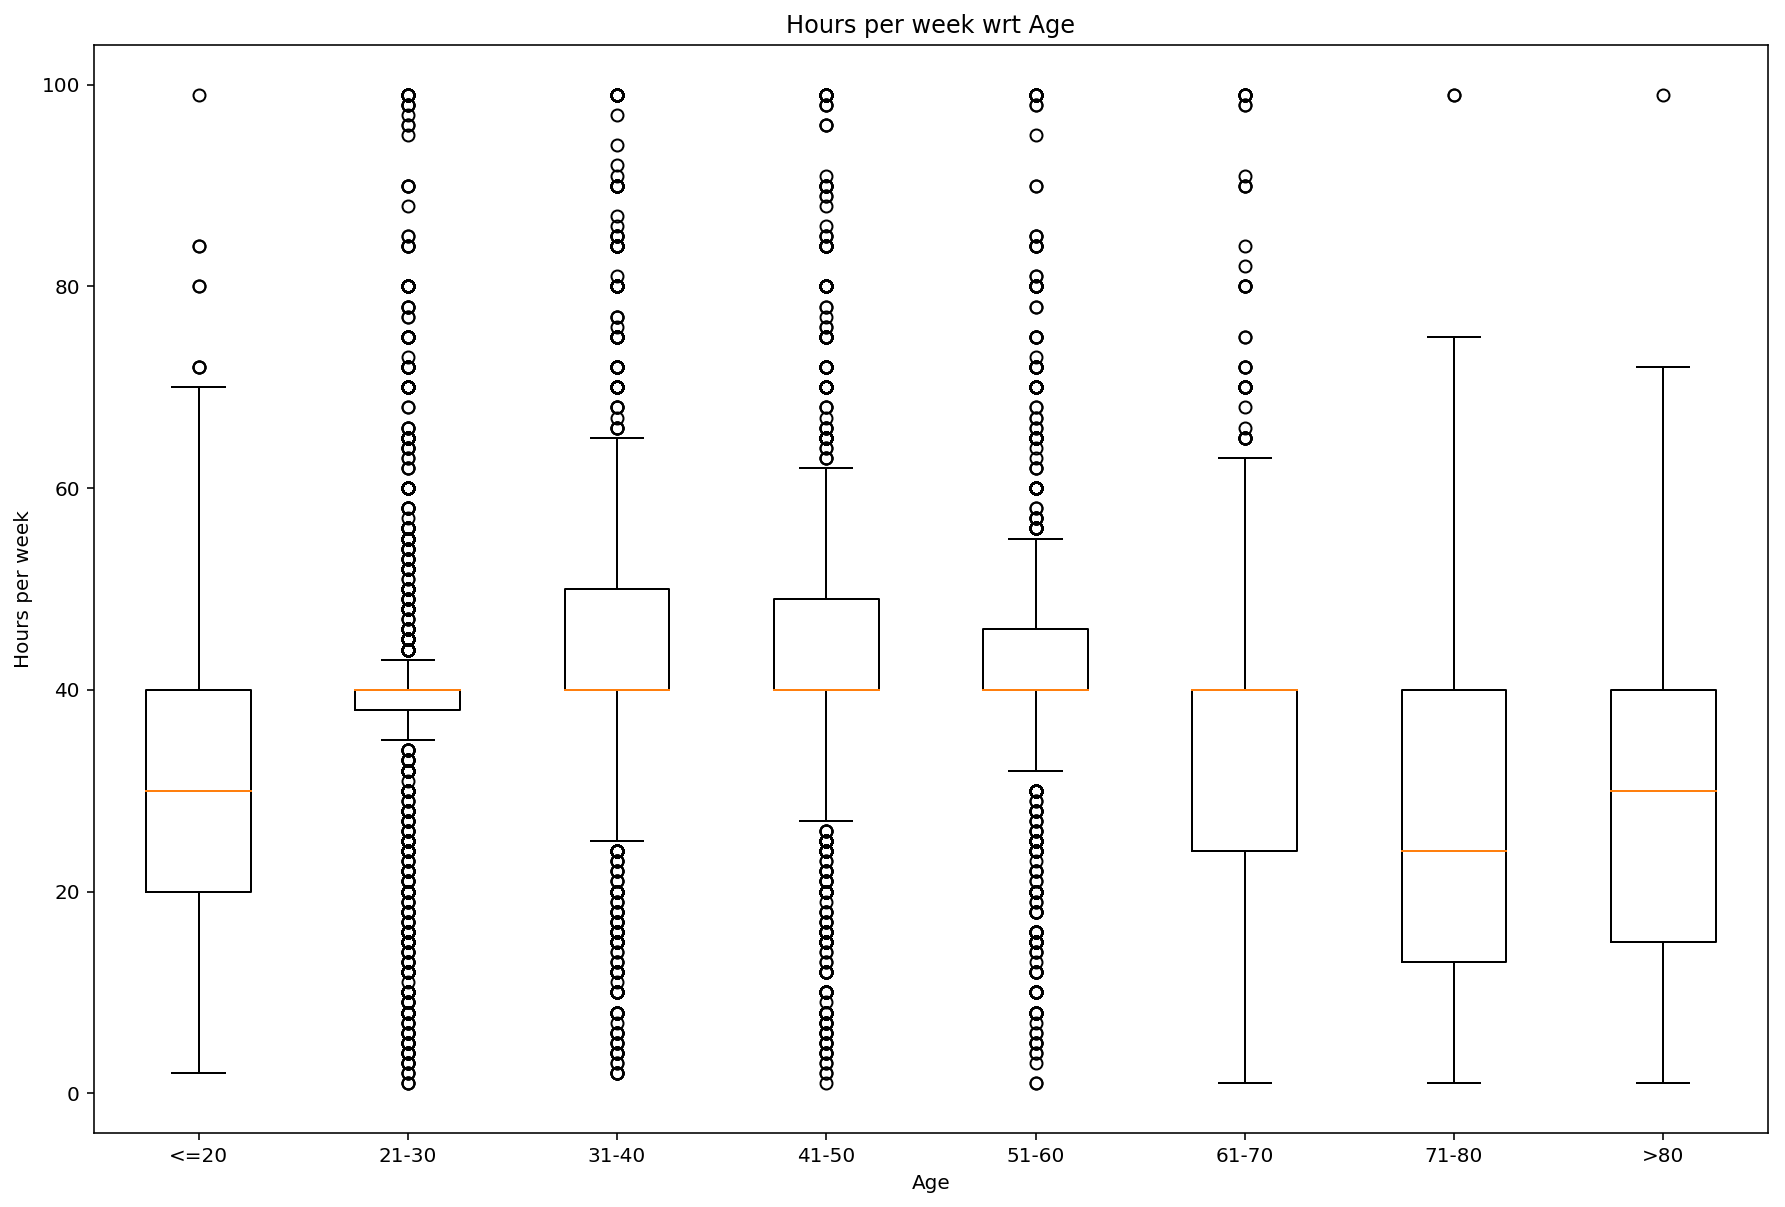

In [7]:
data_to_plot = [adult["hours-per-week"][adult["age"] <= 20], 
                adult["hours-per-week"][(adult["age"] > 20) & (adult["age"] <= 30)], 
                adult["hours-per-week"][(adult["age"] > 30) & (adult["age"] <= 40)],
                adult["hours-per-week"][(adult["age"] > 40) & (adult["age"] <= 50)],
                adult["hours-per-week"][(adult["age"] > 50) & (adult["age"] <= 60)],
                adult["hours-per-week"][(adult["age"] > 60) & (adult["age"] <= 70)],
                adult["hours-per-week"][(adult["age"] > 70) & (adult["age"] <= 80)],
                adult["hours-per-week"][(adult["age"] > 80)]]

fig, ax = plt.subplots(1,1, figsize=(15,10))

bp = ax.boxplot(data_to_plot, labels=["<=20","21-30","31-40","41-50","51-60","61-70","71-80",">80"])

ax.set_xlabel("Age")
ax.set_ylabel("Hours per week")
ax.set_title("Hours per week wrt Age")
plt.grid('off')

The first plot shows the distribution of working hours per week wrt age using boxplot. The task of this plot is to compare the working hours per week wrt age and observe how it changes with age. It encodes the range of "hours per week" within an age bucket with the height of the box, and also represent the average value using the vertical spatial position of a horizontal line. By employing a combination of channels, it displays the distribution of data based on a five number summary (“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”). When I need to have information on the variability or dispersion of the data, boxplot can give me a good indication of how the values in the data are spread out. However, it is hard to identify the original data from it.

We can see from the plot that people of age 21-30 have the longest mean hours and the variance is the smllest, which probably means most people have an equal beginning of their carrer. The mean hours of people of age 31-60 is the same as people of age 21-30, but the variance becomes much larger, especially for 31-40. It may indicates that the people's positions in the company become diverse as they grow from 20s to 30s.

Ref:
Visualization Analysis and Design, 5.4 Using Marks and Channels, 5.5 Channel Effectiveness
Lecture slides: Tasks, https://drive.google.com/file/d/1FmLjam9Ncnz03Hl5If_sVxRjU9DO9NlZ/view

Text(0.5, 1.0, 'Ratio of the Eduaction Levels')

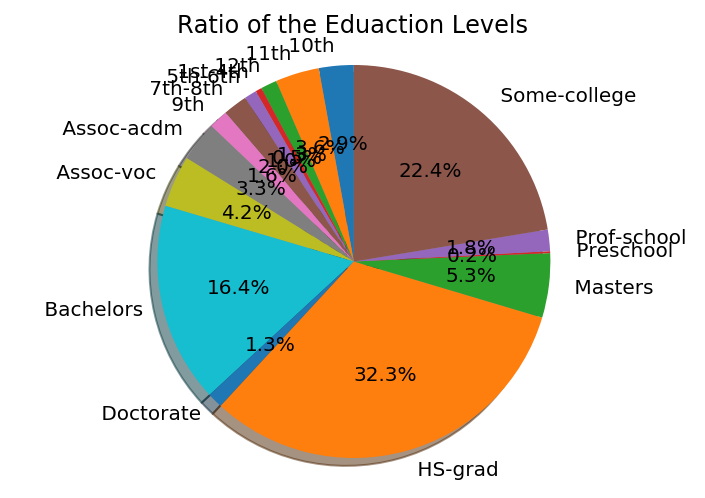

In [8]:
educationCount = adult.groupby("education") \
                      .agg({"education": ["count"]})

labels = educationCount.index
sizes = educationCount["education"]["count"]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Ratio of the Eduaction Levels")

The second plot shows the proportion of each education level in the dataset using pie chart. The task is to explore how different education levels distributed in the data. In the pie chart, the magnitude of the value it represents is encoded with the arc length of each slice (and consequently its central angle and area). The log error rate of the angles channel is about 2.2 with recent crowdsourced results replicating and extending seminal work from Cleveland and McGill [Cleveland and McGill 84a], which is not good.

We can see that the amount of people with HS-grad, Some-college and Bachelors take up the most proportion, and the amount of people with lower or higher education level is much less.

Ref:
Visualization Analysis and Design, 5.4 Using Marks and Channels, 5.5 Channel Effectiveness
Lecture slides: Tasks, https://drive.google.com/file/d/1FmLjam9Ncnz03Hl5If_sVxRjU9DO9NlZ/view

## 2 Preprocess the data

In [9]:
X = adult.drop("label", axis=1)
y = adult["label"]

### One-hot encoding for categorical features

In [10]:
le = LabelEncoder()
X_cat_label = X[["workclass", "education", "marital-status", "occupation", "relationship", \
                 "race", "sex", "native-country"]].apply(le.fit_transform)
X_cat_label.shape

(32561, 8)

In [11]:
y_label = le.fit_transform(y)

In [12]:
enc = OneHotEncoder()
enc.fit(X_cat_label)
X_cat_onehot = enc.transform(X_cat_label).toarray()
X_cat_onehot.shape

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(32561, 102)

### Standardization for continuous features

In [13]:
X_con = X[["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]]
X_con_scaled = scale(X_con)
X_con_scaled.shape

/Users/zexihan/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  


(32561, 6)

### Merge categorical and numerical features

In [14]:
X_cat_onehot.shape, X_con_scaled.shape

((32561, 102), (32561, 6))

In [15]:
X_preprocessed = np.concatenate((X_cat_onehot, X_con_scaled), axis=1)
X_preprocessed.shape

(32561, 108)

## 3 Split the dataset randomly into train/test (80/20)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_label, \
                                                    test_size=0.2, random_state=42)

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26048, 108), (6513, 108), (26048,), (6513,))

## 4 Find the optimal hyperparameters

AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. By analogy, Higher the AUC, better the model is at distinguishing between patients with disease and no disease.

In [18]:
# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
parameters = {'p': [1, 2], 'n_neighbors': range(1, 11)}
scoring = {'AUC': 'roc_auc'}
neigh = KNeighborsClassifier()
clf = GridSearchCV(estimator=neigh, param_grid=parameters, scoring=scoring, \
                   refit='AUC', cv=10, return_train_score=True)
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'p': [1, 2], 'n_neighbors': range(1, 11)},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score=True,
       scoring={'AUC': 'roc_auc'}, verbose=0)

In [19]:
results = pd.DataFrame(clf.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,...,split2_train_AUC,split3_train_AUC,split4_train_AUC,split5_train_AUC,split6_train_AUC,split7_train_AUC,split8_train_AUC,split9_train_AUC,mean_train_AUC,std_train_AUC
0,0.517029,0.045947,4.515115,0.177836,1,1,"{'n_neighbors': 1, 'p': 1}",0.701422,0.711732,0.723868,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,0.545042,0.047955,3.965275,0.204285,1,2,"{'n_neighbors': 1, 'p': 2}",0.712120,0.711614,0.724413,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,0.516990,0.045422,5.867158,0.387139,2,1,"{'n_neighbors': 2, 'p': 1}",0.770607,0.786810,0.794135,...,0.971889,0.971805,0.972458,0.972291,0.972034,0.972370,0.972691,0.971765,0.972330,0.000439
3,0.543353,0.049213,4.839316,0.165447,2,2,"{'n_neighbors': 2, 'p': 2}",0.777689,0.790430,0.793503,...,0.972734,0.972452,0.973104,0.972569,0.972568,0.973117,0.973151,0.972442,0.972935,0.000423
4,0.507846,0.040150,6.708535,0.341549,3,1,"{'n_neighbors': 3, 'p': 1}",0.805394,0.813730,0.822337,...,0.956985,0.957258,0.957758,0.957478,0.956802,0.957169,0.957763,0.957437,0.957625,0.000669


## 5 Create visualization 3

Visualize performance of the algorithm across various values for K (holding p constant at it’s default value of 2 here). Since you’re doing 10-fold cv for each value of K, you actually have 100 values total (10 values for each of the 10 values of K). Please find an appropriate way to encode this data (don’t just make a line chart with the means!)


In [20]:
results_p2 = results[results["param_p"] == 2]
results_p2.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,...,split2_train_AUC,split3_train_AUC,split4_train_AUC,split5_train_AUC,split6_train_AUC,split7_train_AUC,split8_train_AUC,split9_train_AUC,mean_train_AUC,std_train_AUC
1,0.545042,0.047955,3.965275,0.204285,1,2,"{'n_neighbors': 1, 'p': 2}",0.712120,0.711614,0.724413,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,0.543353,0.049213,4.839316,0.165447,2,2,"{'n_neighbors': 2, 'p': 2}",0.777689,0.790430,0.793503,...,0.972734,0.972452,0.973104,0.972569,0.972568,0.973117,0.973151,0.972442,0.972935,0.000423
5,0.537621,0.042972,5.496146,0.415570,3,2,"{'n_neighbors': 3, 'p': 2}",0.808892,0.818287,0.832035,...,0.958435,0.958033,0.959029,0.958821,0.957465,0.958393,0.957789,0.958215,0.958552,0.000710
7,0.517934,0.058756,5.866870,0.232242,4,2,"{'n_neighbors': 4, 'p': 2}",0.826378,0.839115,0.849183,...,0.949460,0.949474,0.950632,0.950141,0.949365,0.949228,0.949221,0.949117,0.949899,0.000784
9,0.531224,0.076186,6.370317,0.410047,5,2,"{'n_neighbors': 5, 'p': 2}",0.841248,0.853365,0.857358,...,0.943262,0.942946,0.943470,0.944187,0.942540,0.942890,0.942421,0.943515,0.943449,0.000779


In [21]:
results_p2.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_neighbors', 'param_p', 'params', 'split0_test_AUC',
       'split1_test_AUC', 'split2_test_AUC', 'split3_test_AUC',
       'split4_test_AUC', 'split5_test_AUC', 'split6_test_AUC',
       'split7_test_AUC', 'split8_test_AUC', 'split9_test_AUC',
       'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC', 'split0_train_AUC',
       'split1_train_AUC', 'split2_train_AUC', 'split3_train_AUC',
       'split4_train_AUC', 'split5_train_AUC', 'split6_train_AUC',
       'split7_train_AUC', 'split8_train_AUC', 'split9_train_AUC',
       'mean_train_AUC', 'std_train_AUC'],
      dtype='object')

In [22]:
# prepare the data to plot
split_test_AUC = [[] for i in range(10)]
split_train_AUC = [[] for i in range(10)]
for i in range(10):
    for j in range(10):
        split_test_AUC[i].append(results_p2.iloc[i]["split"+str(j)+"_test_AUC"])
        split_train_AUC[i].append(results_p2.iloc[i]["split"+str(j)+"_train_AUC"])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


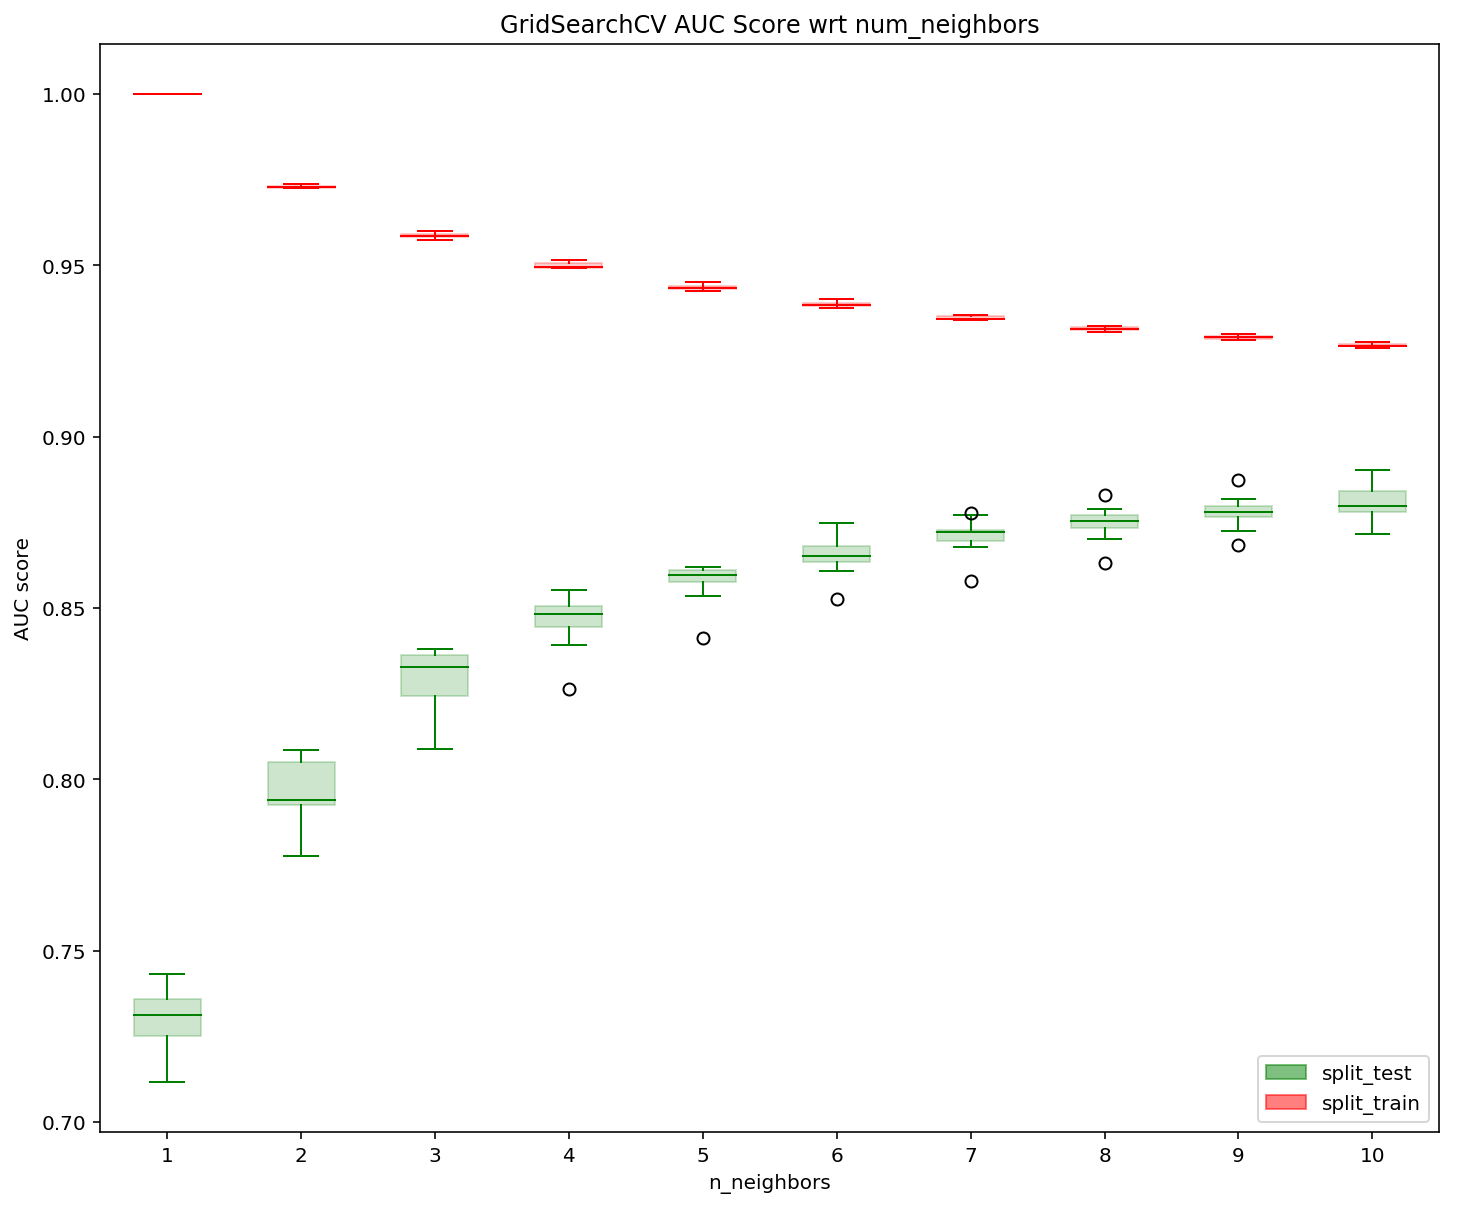

In [23]:
def draw_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color,alpha=0.2)     

# draw boxplot 
fig, ax = plt.subplots(1,1, figsize=(12,10))
draw_plot(split_test_AUC, "g", "g")
draw_plot(split_train_AUC, "r", "r")

# add legend
test_patch = mpatches.Patch(color="g", alpha=0.5, label="split_test")
train_patch = mpatches.Patch(color="r", alpha=0.5, label="split_train")
plt.legend(handles=[test_patch, train_patch], loc="lower right")

# add title and axis labels
ax.set_xlabel("n_neighbors")
ax.set_ylabel("AUC score")
ax.set_title("GridSearchCV AUC Score wrt num_neighbors")
plt.grid('off')

This plot visualizes the performance of the KNN Classigier across various values for K (holding p constant at 2). The task is to analyze how the AUC score changes with K, so as to find an optimal K with the best AUC score. I choose to use boxplot again to show the variation of 10 score values for each of the 10 values of K. It also represent the mean score using the vertical spatial position of a horizontal line. Both train score and test score are included and distinguished by the color channel.

Ref:
Visualization Analysis and Design, 5.4 Using Marks and Channels, 5.5 Channel Effectiveness
Lecture slides: Tasks, https://drive.google.com/file/d/1FmLjam9Ncnz03Hl5If_sVxRjU9DO9NlZ/view

## 6 Predict the values for test set and report performance

In [24]:
best_params = clf.best_params_
best_params

{'n_neighbors': 10, 'p': 2}

In [25]:
best_clf = clf.best_estimator_
y_pred = best_clf.predict(X_test)

In [26]:
# compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(4611, 331, 682, 889)

In [27]:
# compute Area Under the Curve (AUC) 
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc(fpr, tpr)

0.7494523358289064